<h1 id="tocheading">Finding Patterns in Data using IBM Power and PowerAI</h1>
**TODO** : Insert nice banner here
(techu / powerAI / sklearn / tensorflow /keras banner here)
<div id="toc"></div>

In this lab we will explore an open source data set, and discover how we can use the tools that are part of PowerAI to explore and discover patterns in the data.  For this lab, we will make use of the Lending Club data set.  Here is a brief description about Lending Club.


<img src="https://github.com/CatherineCao2016/pics/raw/master/lcintro.png" width="800" height="500" align="middle"/>

[Lending Club (LC)](https://www.lendingclub.com/) is the world’s largest online marketplace connecting borrowers and investors. It is transforming the banking system to make credit more affordable and investing more rewarding. Lending Club operates at a lower cost than traditional bank lending programs and pass the savings on to borrowers in the form of lower rates and to investors in the form of solid risk-adjusted returns.

The original data set is downloaded from [LC](https://www.lendingclub.com/info/download-data.action) covering complete loan data for all loans issued through the 2007-2018, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. Additional features include credit history, number of finance inquiries, address including zip codes, and state, and collections among others. It is quite rich and is really the only quality source of credit risk data we could locate; there is a large amount of value in the data and companies guard it relentlessly. Goldman Sachs’ new peer-to-peer lending platform called Marcus was built almost entirely using the Lending Club data.

**Important**

In this notebook, we will play with the LC data, conduct a set of exploratory analysis and try to apply various machine learning techniques to predict borrower’s default. We took a small sample of loans made in 2017 (150K) to help speed up the processing time for the lab


Note : to remove a lot of the busy verbose code, we are making using of a utility python file called lc_utils.py.  For implemenation details you can refer here  **TODO : link**

## Quick word on the data science method
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/dsx-methodology.png" width="900" height="700" align="middle"/>

Here we will use these simple high level steps to work through a typical data science problem.  This workflow is meant to be a high level guide, but in practice this is a highly iterative approach ...


### Problem Understanding

**High level use case** - predict credit default analysis using lendingclub.com data

**TODO** - add some commentary here

**TODO** - link data dictionary, and add some commentary

### Goals

* Perform some initial analysis of the data for **Business Understanding**
* **Prepare the Data** for our visualization and modeling
* **Visualize** the data
* Model using **Dimension Reduction** and **Classification** techniques
* **Evaluate** the approach

## Data Understanding and Preparation
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/data-preparation.png" width="800" height="500" align="middle"/>

### Import Libraries

In [133]:
# Code functions that are needed to run this lab
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math

import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob

# custom library for some helper functions 
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


from lc_utils import *

In [134]:
# TODO : remove later ....

%load_ext autoreload
%autoreload 2
#%unload_ext lc_utils
#from lc_utils import *
# %reload_ext lc_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the Data
Here we load data that was previously downloaded from lendingclub.com.  For speed of this lab, we are restricting the number of loans ~ 180K

In [135]:
loan_df = load_sample_data()
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,16098.340000,16098.34,16000.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,16630.580000,16630.58,15143.02,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939

### Descriptive Statistics (1D)
Lets look at some 1D and 2D descriptive statistics for this dataset

In this dataset, we have all types of data.  Numerical, Categorical, Ranked data.  This small module will take you through what is typical done to quickly understand the data



In [136]:
quick_overview(loan_df)

**quick_overview** : There are 133889 observations in the dataset.
**quick_overview** : There are 151 variables in the dataset.
**quick_overview** : 
Categorical vs Numerical
**quick_overview** : use df.dtypes ...
float64    112
object      39
Name: type, dtype: int64
**quick_overview** : 
******************Dataset Descriptive Statistics (numerical columns only) *****************************

 running df.describe() ....


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133870.000000,133887.000000,133887.000000,133887.000000,133886.000000,69322.000000,23671.000000,133887.000000,133887.000000,1.338870e+05,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,38074.000000,133887.0,2661.000000,2659.000000,133887.000000,133887.000000,1.338870e+05,133825.000000,133826.000000,133826.000000,133826.000000,130186.000000,133826.000000,116008.000000,133826.000000,133826.000000,133826.000000,133820.000000,1.338870e+05,133826.000000,133825.000000,133825.000000,133887.000000,133887.000000,132776.000000,132712.000000,133887.000000,133887.000000,130241.000000,133887.000000,133887.000000,133887.000000,133887.000000,132843.000000,33756.000000,120089.000000,47783.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.00000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,126266.000000,133887.000000,133887.000000,133887.000000,133887.000000,132758.000000,133887.000000,133887.000000,1.338870e+05,1.338870e+05,1.338870e+05,1.338870e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,774.0,774.000000,774.0,774.000000,635.000000,774.000000,774.000000,1087.000000,1087.000000,1087.000000
mean,NaN,15589.394041,15589.394041,15581.984023,460.863923,8.046397e+04,19.547033,0.343476,695.750633,699.750827,0.576498,33.807810,66.361413,12.119922,0.238709,1.861627e+04,25.343245,5695.480540,5692.970475,10951.511813,10946.224173,8583.266797,2292.920647,1.102888e+00,74.221479,13.246068,3186.572260,687.161039,676.487710,0.021257,45.218154,1.0,108617.690135,18.603103,0.006969,259.246596,1.472398e+05,1.045373,2.797147,0.747157,1.625215,21.641175,35704.147819,70.741044,1.373769,2.930006,6183.582271,60.654499,3.636171e+04,0.952924,1.544121,2.187215,4.799159,13509.653738,10857.383932,59.762205,0.010120,21.343491,127.552652,188.682553,13.155243,7.799757,1.671402,23.845607,38.836799,6.812589,35.217672,0.518908,3.809533,5.917796,4.955836,8.00

Here we can get a quick assessment of the statistics for each column.  
**Quick Question** can you answer what was the average income for the 188K loan applicants ?

### Descriptive Statistics (2D)
Since we have 113 numerical variables, creating a 2D correlation plot may be time consuming and difficult to interpret

**TODO** write a nice util that shows just a couple vars of interest ....

### Create Loan Default column.  This is the column we will predict later
The **loan_status** column contains the information of whether or not the loan is in default. Here we will look at all the categorical values in loan_status, and create a new column based off that one.


In [137]:
loan_df = create_loan_default(loan_df)

**create_loan_default** : Unique values in loan_status
Current               79931
Fully Paid            35650
Charged Off           13043
Late (31-120 days)     3157
In Grace Period        1637
Late (16-30 days)       458
Default                  11
Name: loan_status, dtype: int64
**create_loan_default** : Dropping other values that are highly correlated with loan_status
**create_loan_default** : Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv
**create_loan_default** : Unique values in default
0    117220
1     16669
Name: default, dtype: int64


### Handle Null Values ... Impute later for key columns ....

* handle null values (fill zero, impute mean/median/min/max/other, drop, etc)
* handle values that need to be re-cast (ie string to int, etc etc)


In [138]:
loan_df.describe()
columns_with_nans(loan_df)

**columns_with_nans** : id                                                 0
member_id                                     133889
loan_amnt                                          2
funded_amnt                                        2
funded_amnt_inv                                    2
term                                               2
int_rate                                           2
installment                                        2
grade                                              2
sub_grade                                          2
emp_title                                       8983
emp_length                                      8946
home_ownership                                     2
annual_inc                                         2
verification_status                                2
issue_d                                            2
pymnt_plan                                         2
url                                                2
desc                  


As you can see, we have some work to do to clean up the NaN values.  ... Luckily, we took care to process and clean this data below using a routine.  In practice, this is where data scientists spend a large portion of their time as this requires detailed domain knowledge to clean the data.  We have made a fair nubmer of assumptions about how to process the data which we won't go into due to time contraints for the lab.

In [139]:
#loan_df1 = drop_sparse_numeric_columns(loan_df)
#loan_df2 = drop_columns(loan_df1)
#loan_df3 = impute_columns(loan_df2)
#loan_df4 = handle_employee_length(loan_df3)
#loan_df5 = handle_revol_util(loan_df4)
#loan_df6 = drop_rows(loan_df5)

loan_df = clean_lendingclub_data(loan_df)


**clean_lendingclub_data** :  Running a couple routines to clean the data ...
**drop_sparse_numeric_columns** : Dropping columns with less than 0.01 pct cells populated
**transform** : Dropping member_id since its 0.0 pct populated
**transform** : Dropping revol_bal_joint since its 0.0 pct populated
**transform** : Dropping sec_app_fico_range_low since its 0.0 pct populated
**transform** : Dropping sec_app_fico_range_high since its 0.0 pct populated
**transform** : Dropping sec_app_earliest_cr_line since its 0.0 pct populated
**transform** : Dropping sec_app_inq_last_6mths since its 0.0 pct populated
**transform** : Dropping sec_app_mort_acc since its 0.0 pct populated
**transform** : Dropping sec_app_open_acc since its 0.0 pct populated
**transform** : Dropping sec_app_revol_util since its 0.0 pct populated
**transform** : Dropping sec_app_open_act_il since its 0.0 pct populated
**transform** : Dropping sec_app_num_rev_accts since its 0.0 pct populated
**transform** : Dropping sec_app

In [140]:
# Final Sanity check ....
columns_with_nans(loan_df)

**columns_with_nans** : id                            0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_rec_int   

### Data Preparation - Handle Time Objects
Sometimes for columns that contain date information, you may want to break them down into individual columns like month, day, day of week etc.  For our use case, we will create a new column called `time_history` that will indicate how long an applicant has been a borrower.  This is an example of **feature engineering**.  Essentially, using business logic to create a new column (feature) that may have predictive value.

In [141]:
loan_df = create_time_features(loan_df)

**create_time_features** : Creating new column called time_history : Calculated feature showing how long applicant has been a borrower..


### Convert Categorical Data to One hot encode ###
**TODO** explain here 

In [142]:
loan_df = one_hot_encode_keep_cols(loan_df)

**one_hot_encode_keep_cols** : Dropping these columns since they are greater than cardinality limit of 50
**one_hot_encode_keep_cols** : ['id', 'int_rate', 'zip_code', 'addr_state', 'application_type', 'verification_status_joint', 'disbursement_method']
**one_hot_encode_keep_cols** : Keeping these cols
**one_hot_encode_keep_cols** : ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'debt_settlement_flag', 'emp_bin']


### Final Result after data prep ....

In [143]:
loan_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,default,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,small_business,vacation,f,w,N,Y,0_3yrs,4_6yrs,gt_6yrs,id
88,35000.0,35000.0,35000.0,778.38,89000.0,2016-03-01,19.66,2.0,1993-10-01,680.0,684.0,0.0,8.0,0.0,44720.0,17.0,25665.11,25665.11,5796.92,0.0,0.0,0.0,800.00,724.0,720.0,0.0,1.0,110500.0,19.94,2.0,0.0,1.0,0.0,1.0,21.0,6959.0,81.0,0.0,0.0,16006.0,75.0,0.0,0.0,0.0,1.0,14488.0,7275.0,82.0,0.0,1120.0,2.0,88.2,75.0,0.0,0.0,51679.0,40500.0,0,0.560963,8187,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,73640145
92,12000.0,12000.0,12000.0,382.50,35000.0,2016-03-01,48.25,1.0,2001-09-01,715.0,719.0,0.0,10.0,3.0,5427.0,18.0,6076.25,6076.25,1331.54,0.0,0.0,0.0,382.50,694.0,690.0,0.0,1.0,60000.0,29.60,0.0,0.0,4.0,0.0,0.0,28.0,35378.0,77.0,0.0,2.0,1847.0,75.0,0.0,7.0,0.0,2.0,4081.0,453.0,80.3,0.0,0.0,3.0,77.8,100.0,2.0,0.0,40805.0,2300.0,0,0.311413,5295,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,75971893
165,8000.0,8000.0,8000.0,260.97,40000.0,2016-03-01,19.35,0.0,2004-10-01,670.0,674.0,1.0,7.0,1.0,5451.0,10.0,4097.98,4097.98,1046.85,0.0,0.0,0.0,260.97,709.0,705.0,0.0,1.0,80000.0,10.53,0.0,1.0,1.0,0.0,0.0,32.0,16516.0,63.0,2.0,5.0,2909.0,61.0,0.0,0.0,2.0,5.0,25900.0,1590.0,72.6,0.0,0.0,2.0,88.9,0.0,0.0,1.0,21967.0,5800.0,0,0.405249,4169,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,74864303
205,12025.0,12025.0,12025.0,413.68,32000.0,2016-03-01,19.88,0.0,2005-09-01,705.0,709.0,0.0,9.0,0.0,10411.0,11.0,6324.66,6324.66,2140.26,0.0,0.0,0.0,413.68,749.0,745.0,0.0,1.0,90000.0,30.17,0.0,1.0,1.0,1.0,1.0,3.0,8991.0,92.0,0.0,0.0,8077.0,68.0,0.0,0.0,1.0,1.0,21098.0,878.0,91.8,0.0,0.0,2.0,100.0,75.0,0.0,0.0,19402.0,10700.0,0,0.464031,3834,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,76053327
508,4000.0,4000.0,4000.0,130.49,2400.0,2016-03-01,343.50,0.0,1976-03-01,710.0,714.0,0.0,12.0,0.0,18648.0,25.0,2048.89,2048.89,523.42,0.0,0.0,0.0,130.49,759.0,755.0,0.0,1.0,55272.0,20.97,0.0,0.0,1.0,1.0,2.0,12.0,6182.0,78.0,0.0,2.0,3299.0,49.0,1.0,4.0,1.0,4.0,2483.0,3675.0,60.5,0.0,0.0,4.0,100.0,50.0,0.0,0.0,24830.0,9300.0,0,0.823384,14610,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,76042140


<img src="https://github.com/dustinvanstee/random-public-files/raw/master/data-visualization.png" width="800" height="500" align="middle"/>

### Data Visualization
As you saw, when you 'describe' a data frame, you get a table statistics showing you the mean,min,max and other statistics about each column.  This is good, but sometimes its also good to look at the histograms of the data as well.  Lets Visualize some of the distributions from our dataset


In [ ]:
plot_histograms(loan_df)

skipping column issue_d of type  datetime64[ns]
skipping column earliest_cr_line of type  datetime64[ns]
skipping column  36 months of type  uint8
skipping column  60 months of type  uint8
skipping column A of type  uint8
skipping column B of type  uint8
skipping column C of type  uint8
skipping column D of type  uint8
skipping column E of type  uint8
skipping column F of type  uint8
skipping column G of type  uint8
skipping column A1 of type  uint8
skipping column A2 of type  uint8
skipping column A3 of type  uint8
skipping column A4 of type  uint8
skipping column A5 of type  uint8
skipping column B1 of type  uint8
skipping column B2 of type  uint8
skipping column B3 of type  uint8
skipping column B4 of type  uint8
skipping column B5 of type  uint8
skipping column C1 of type  uint8
skipping column C2 of type  uint8
skipping column C3 of type  uint8
skipping column C4 of type  uint8
skipping column C5 of type  uint8
skipping column D1 of type  uint8
skipping column D2 of type  uint8
sk

In [ ]:
### A word on visualization libararies.


# Brunel Example
## The Growth of Lending Club
### Here we use the builtin Brunel Visualization graphics package
Lending club has been expanding over the years in terms of total loan volume and average loan size.

In [ ]:
# Build a statistics data frame based on issue date
# aggregate on loan amount
# loan_stats = pd.concat([loan_df.groupby('issue_d').mean()['loan_amnt'].to_frame().rename(columns = {'loan_amnt':'loan_average'}), loan_df.groupby('issue_d')['loan_status'].count().to_frame().rename(columns = {'loan_status':'loan_count'})], axis=1)

In [ ]:
#%brunel data('loan_stats') line x(ISSUE_D) y(loan_average, loan_count) color(#series) tooltip(#all) :: width=900, height=350 

**TODO** Add more Brunel if i get it in nimbix

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/modeling.png" width="800" height="500" align="middle"/>

### Train / Test set creation

In [ ]:
%load_ext autoreload
%autoreload 2
from lc_utils import *

In [ ]:
loan_df.head()
my_analysis = lendingclub_ml(loan_df)

In [ ]:
# Create a train / test split of your data set.  Paramter is test set size percentage 
# Returns data in the form of dataframes
my_analysis.create_train_test(test_size=0.4)

In [ ]:
### Correlation to defualt [REMOVE]
#my_analysis.train_df.dtypes
corr_vs_1var(my_analysis.train_df, 'default')
#my_analysis.train_df.head()
#my_analysis.train_df['default'].corr(my_analysis.train_df['TX'])

In [114]:
my_analysis.X_train_scaled.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,NONE,OTHER,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,MS,MT,NC,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,f,w,N,Y,0_3yrs,4_6yrs,gt_6yrs
0,-0.536967,-0.536808,-0.535682,-0.863344,-0.662960,0.139827,-0.341251,1.102897,1.102876,0.188436,-0.003541,-0.264043,-0.361688,-0.592888,-0.190598,-0.190584,0.215489,-0.136734,-0.225641,-0.172156,-0.671318,0.346463,0.307668,-0.054552,0.0,-0.043698,0.023597,-0.131587,1.107656,-1.138483,-0.06521,-0.015264,-0.361638,0.540185,-0.883203,-0.290607,-0.062927,-0.400694,0.654350,-0.003317,-0.927682,-1.803423,1.803423,-0.424071,-0.704952,1.663578,-0.418621,-0.262509,-0.177933,-0.07703,-0.152465,-0.152191,-0.164846,-0.196462,-0.213132,-0.240859,-0.273369,-0.300742,-0.288293,-0.224379,3.983979,-0.244827,-0.235754,-0.231453,-0.219857,-0.201299,-0.182051,-0.167015,-0.167993,-0.155151,-0.115485,-0.127532,-0.11354,-0.112333,-0.101083,-0.09362,-0.085374,-0.078984,-0.069194,-0.061758,-0.048778,-0.039287,-0.031086,-0.02344,-0.021671,0.967218,-0.016028,-0.01575,-0.298794,-0.817986,-0.674662,-0.537717,1.077133,0.011136,-0.011136,-0.103251,-0.544488,0.827476,-0.239436,-0.075265,-0.141588,-0.090737,-0.075917,-0.221798,-0.026628,-0.120198,-0.07022,-0.084315,-0.055362,-0.11358,-0.086576,-0.1521,-0.440882,-0.14784,-0.125254,-0.054224,-0.050833,-0.269967,-0.180591,-0.0783,-0.002976,-0.002976,-0.203575,-0.110705,-0.098732,10.432290,-0.11013,-0.155151,-0.153042,-0.158794,-0.131038,-0.126126,-0.005155,-0.055603,-0.172238,-0.002976,-0.067889,-0.199722,-0.074427,-0.121292,-0.305964,-0.180957,-0.09529,-0.115995,-0.185782,-0.064307,-0.10704,-0.047107,-0.104254,-0.28975,-0.089035,-0.178172,-0.040621,-0.156284,-0.1105,-0.070728,-0.049232,0.516754,-0.516754,0.095479,-0.095479,-0.502855,2.023017,-1.229372
1,-1.091565,-1.091536,-1.090802,-1.085800,-0.952633,0.047860,-0.341251,0.270666,0.270658,-0.778298,-0.436480,-0.264043,-0.295946,-1.043409,-0.190598,-0.190584,-0.915731,-0.136734,-0.225641,-0.172156,0.215228,0.090458,0.135547,-0.054552,0.0,-0.043698,-0.741883,-0.686882,1.208324,-1.097384,-0.06521,-0.015264,-0.823998,0.540185,-0.977035,-0.290607,-0.062927,-0.792317,0.788299,1.001591,-0.869039,0.554501,-0.554501,-0.424071,1.418536,-0.601114,-0.418621,-0.262509,-0.177933,-0.07703,-0.152465,-0.152191,-0.164846,-0.196462,-0.213132,-0.240859,3.658053,-0.300742,-0.288293,-0.224379,-0.251005,-0.244827,-0.235754,-0.231453,-0.219857,-0.201299,-0.182051,-0.167015,-0.167993,-0.155151,-0.115485,-0.127532,-0.11354,-0.112333,-0.101083,-0.09362,-0.085374,-0.078984,-0.069194,-0.061758,-0.048778,-0.039287,-0.031086,-0.02344,-0.021671,-1.033893,-0.016028,-0.01575,-0.298794,1.222515,1.482224,-0.537717,-0.928390,0.011136,-0.011136,-0.103251,-0.544488,0.827476,-0.239436,-0.075265,-0.141588,-0.090737,-0.075917,-0.221798,-0.026628,-0.120198,-0.07022,-0.084315,-0.055362,-0.11358,-0.086576,-0.1521,-0.440882,-0.14784,-0.125254,-0.054224,-0.050833,-0.269967,-0.180591,-0.0783,-0.002976,-0.002976,-0.203575,-0.110705,-0.098732,-0.095856,-0.11013,-0.155151,-0.153042,-0.158794,-0.131038,-0.126126,-

For this modeling exercise we will perform a couple of tasks, dimension reduction and classification as shown in the following diagram.

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-workflow.png" width="800" height="500" align="middle"/>

**Dimension Reduction** is useful in scenarios when you have a large number of columns and you would like to reduce that down to a compressed representation .  In this lab we will try 2 methods of dimension reduction.  It will be your choice to decide which method you want to use for the classification part of the lab ! (you could even decice to bypass this if you want ...)


## Dimension Reduction - PCA

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-pca.png"  width="200" height="125" align="middle"/>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.

**build_pca_model** : Explained Variance : [0.04665466 0.0340707  0.02028403 0.01703376 0.01569618 0.01486809
 0.01444454 0.01371793 0.01324962 0.01286009 0.01261602 0.01250799
 0.01210142 0.01197131 0.01135554 0.01066361 0.01021882 0.0097022
 0.00951491 0.00895426 0.00840441 0.00771891 0.00743179 0.00734475
 0.0071173  0.00685911 0.00678286 0.00666884 0.00664472 0.0065376
 0.00647888 0.00647146 0.0064245  0.00641694 0.00639565 0.00636066
 0.00635046 0.00634379 0.00632267 0.00630922 0.00629146 0.00628204
 0.0062648  0.00625744 0.00624163 0.00623742 0.00622634 0.00622086
 0.00620044 0.00618628]


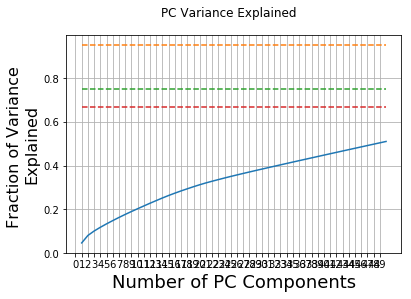

In [115]:
# dim red using PCA
my_analysis.build_pca_model(n_components=50)


## Dimension Reduction - AutoEncoder

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-ae.png"  width="600" height="375" align="middle"/>

**TODO : AE Writeup **

In [116]:
my_analysis.build_ae_model(ae_layers=[100,25,6,25,100], regularization=0.001, epochs=1, folds=2, k_tries=1)

**build_ae_model** : Dataframe shape = (112908, 164)
**build_ae_model** : idx=0, xlen=112908 trainlen=56454 cvlen=56454
**build_ae_model** : idx=1, xlen=112908 trainlen=56454 cvlen=56454
**build_ae_model** : Building Autoencoder using this definition : 164 [100, 25, 6, 25, 100] 164 
**build_ae_model** : Inner Loop encoding_dim : [100, 25, 6, 25, 100], regular=0.001, kfold_iter=0
**build_ae_model** : X_train shape=(56454, 164) X_CV shape=(56454, 164)
Train on 56454 samples, validate on 56454 samples
Epoch 1/1
56454/56454 [==============================] - 4s 69us/step - loss: 1.3120 - val_loss: 1.3289
**build_ae_model** : Recon err = 1.3119789308276402 : Current Iter err = 1.3119789308276402
**build_ae_model** : Inner Loop encoding_dim : [100, 25, 6, 25, 100], regular=0.001, kfold_iter=1
**build_ae_model** : X_train shape=(56454, 164) X_CV shape=(56454, 164)
Train on 56454 samples, validate on 56454 samples
Epoch 1/1
56454/56454 [==============================] - 3s 61us/step - loss: 1.

# Now update our test dataframe with new columns that are predicted by our PCA and Autoencoder models.  
Here we will now take the models that we built and pass our test data set through the models.   By doing this, we will have reduced the number features in our data set by a significant amount (177 => 5!)  .  

In this step we will add new columns to our test/train data frames for both our PCA model and our autoencoder model.  This is required for some followon visualization, and training steps ahead

In [117]:
my_analysis.update_train_test_df()

**update_df** : Starting update for train dataframe 
**update_df** : Adding PCA columns first
**update_df** : Creating new columns : {0: 'PC0', 1: 'PC1', 2: 'PC2', 3: 'PC3', 4: 'PC4', 5: 'PC5', 6: 'PC6', 7: 'PC7', 8: 'PC8', 9: 'PC9', 10: 'PC10', 11: 'PC11', 12: 'PC12', 13: 'PC13', 14: 'PC14', 15: 'PC15', 16: 'PC16', 17: 'PC17', 18: 'PC18', 19: 'PC19', 20: 'PC20', 21: 'PC21', 22: 'PC22', 23: 'PC23', 24: 'PC24', 25: 'PC25', 26: 'PC26', 27: 'PC27', 28: 'PC28', 29: 'PC29', 30: 'PC30', 31: 'PC31', 32: 'PC32', 33: 'PC33', 34: 'PC34', 35: 'PC35', 36: 'PC36', 37: 'PC37', 38: 'PC38', 39: 'PC39', 40: 'PC40', 41: 'PC41', 42: 'PC42', 43: 'PC43', 44: 'PC44', 45: 'PC45', 46: 'PC46', 47: 'PC47', 48: 'PC48', 49: 'PC49'}
**update_df** : Adding AE columns next
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 164)               0         
_________________________________________________

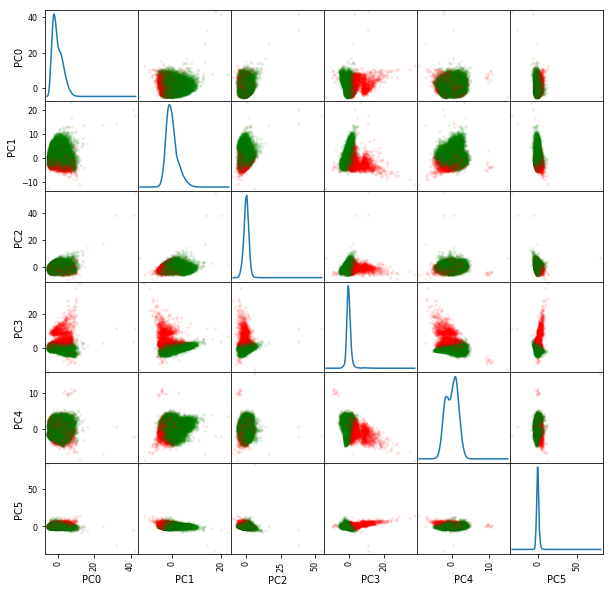

In [118]:
my_analysis.visualize_dimred_results(mode='pca')

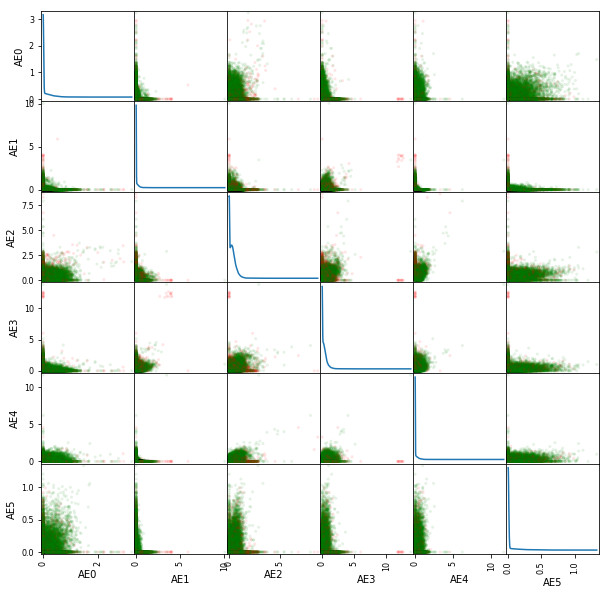

In [119]:
my_analysis.visualize_dimred_results(mode='ae')

**corr_vs_1var** : removing object types
Highest Positive                                             Highest Negative    
Correlation                                                  Correlation         
==============                                               ==============      
(' 36 months', -0.5968074539772396)                          ('AE4', 0.30798971930788127)
('B', -0.2423293155132563)                                   ('AE3', 0.2867353931681804)
('pub_rec_bankruptcies', -0.15416559486163003)               ('AE2', 0.24482523786328084)
('pub_rec', -0.15373841646874728)                            ('gt_6yrs', 0.20478671450617844)
('revol_util_1', -0.10730386700681922)                       ('AE0', 0.12181979347336312)
('A2', -0.050851668331166805)                                ('PC41', 0.1055222072816201)
('collections_12_mths_ex_med', -0.0368537359494575)          ('TX', 0.10353599575823483)
('tax_liens', -0.03403666306084862)                          ('PC12', 0.087656771

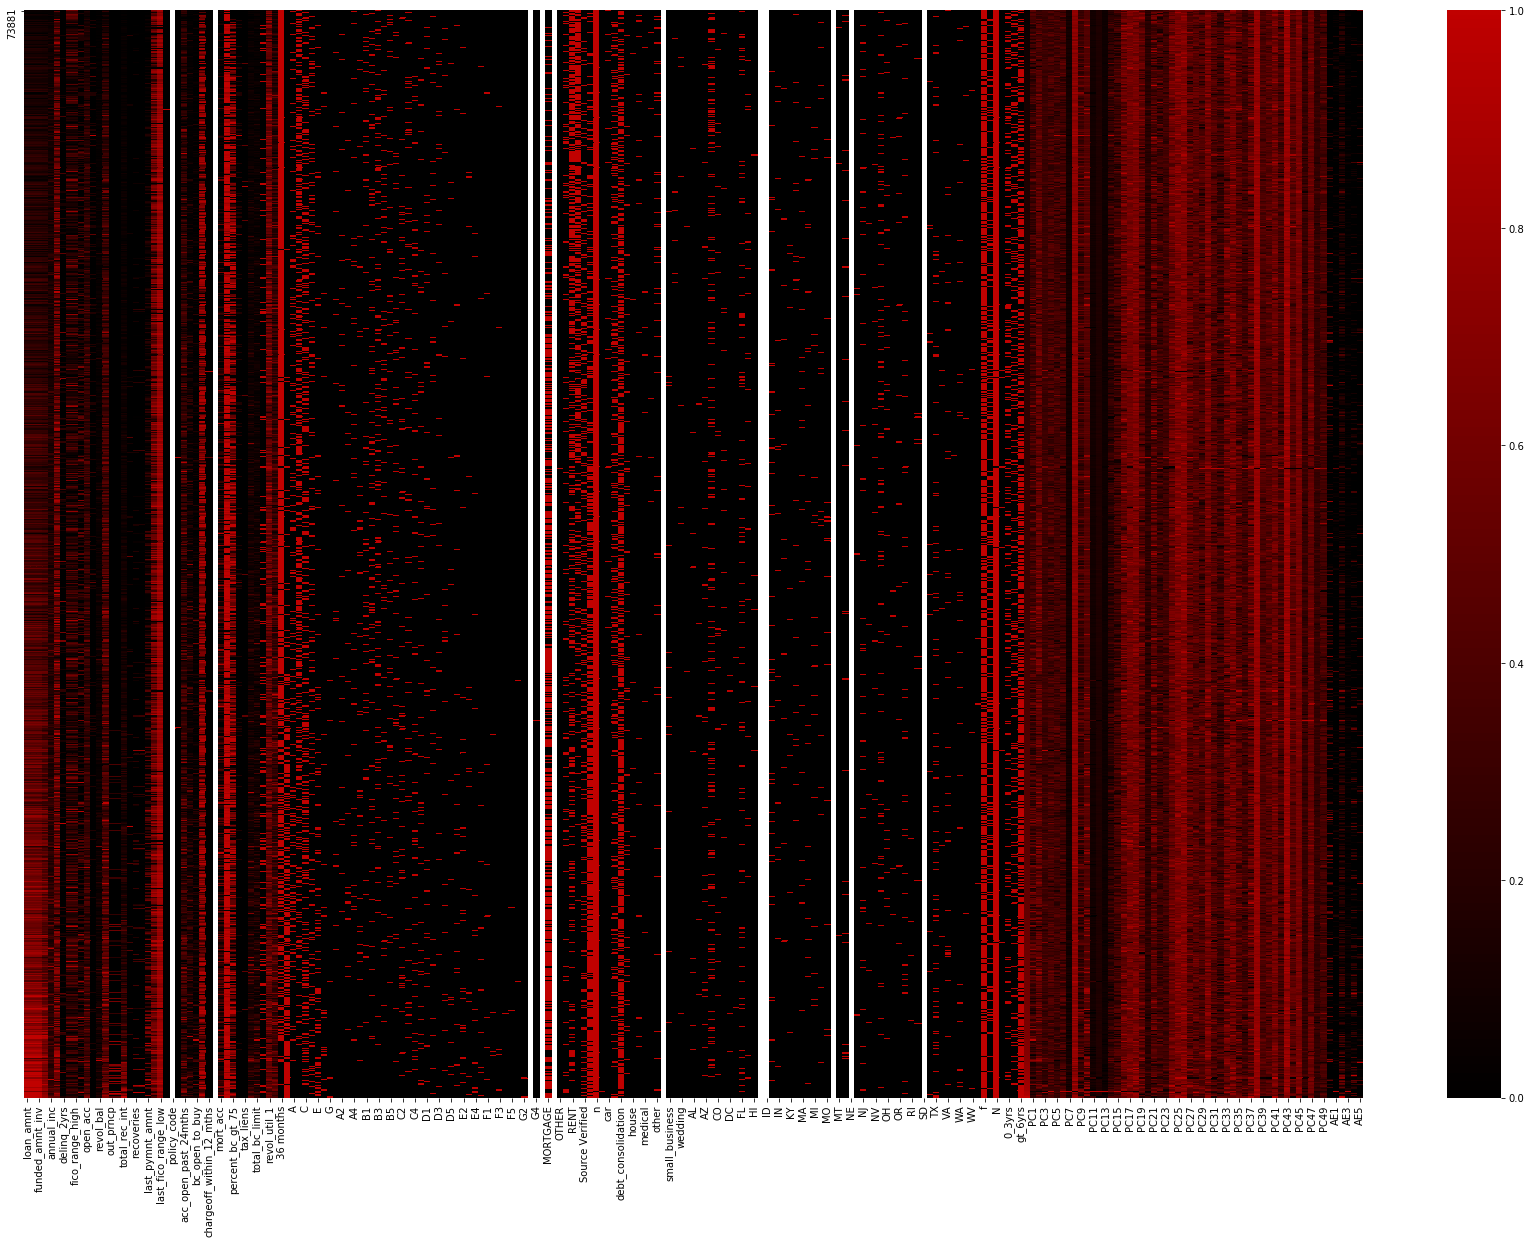

In [120]:
bob_heatmap_lc(my_analysis.test_df,sortColumn='PC0',add_corr=1)

# Final Step - Lending Club Default Prediction

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-traintest.png"  width="600" height="375" align="middle"/>

Here we will build a classifier to predict if loan will fail or not.  We will us a 
** Deep Learning Classifier **  .  You will have 3 options for data sources, 
* the raw data
* PCA dimension reduction features
* Autoencoder features

To evaluate our model, we will use a simple contingency table.  However, this is a fairly simplistic method.  Better method that can data scientists use are F1 score, and PR/ROC curves.

Step 1 here is to set our baseline result.  In this example, we are dealing with a **skewed** dataset.  This means, on average, most people will not default, and they pay their loan off.  If you built a classifier that just predicted no default, you would be right most of the time.  Lets see the stats from our dataset below....

In [121]:
# Set our baseline
my_analysis.train_df['default'].describe()


count    112908.000000
mean          0.155277
std           0.362170
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

As you can see, only 15.5% of the applicants default.  Any classifier we build must be better than this, or we aren't doing a very good job ;)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 50)                0         
_________________________________________________________________
FC0 (Dense)                  (None, 10)                510       
_________________________________________________________________
final_layer (Dense)          (None, 1)                 11        
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________
Train on 112908 samples, validate on 75273 samples
Epoch 1/25
112908/112908 [==============================] - 7s 65us/step - loss: 0.0989 - val_loss: 0.0737
Epoch 2/25
112908/112908 [==============================] - 7s 63us/step - loss: 0.0690 - val_loss: 0.0659
Epoch 3/25
112908/112908 [==============================] - 7s 64us/step - loss: 0.0635 - val_loss: 0.0619
Epoch 4/25
112908/112908 [==========

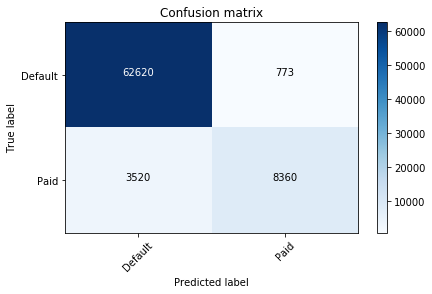

In [123]:
mode = 'pca' # ae , all, 

if(mode == 'pca') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' in x]
elif(mode == 'ae') :
            x_cols = [x for x in my_analysis.train_df.columns if 'AE' in x]
elif(mode == 'all') :
            x_cols = [x for x in my_analysis.train_df.columns if 'AE' in x]

my_analysis.build_evaluate_dl_classifier(x_cols, epochs=25)


In [ ]:
94.6% !
plot learning rate !!

### Credits (TODO)
* [Data Preparation](https://apsportal.ibm.com/analytics/notebooks/9ef75f73-140a-4618-9292-1de51f5f331c/view?projectid=399ab81a-5140-4d51-a5df-b6e82d51db85&context=analytics)
* [Data Visualization](https://apsportal.ibm.com/analytics/notebooks/24dd6830-8a01-4bde-b42d-1d040079af16/view?projectid=399ab81a-5140-4d51-a5df-b6e82d51db85&context=analytics)
* [Modelling/Eval/Deploy](https://apsportal.ibm.com/analytics/notebooks/2d84420b-e005-4b95-99f6-a56148305fbc/view?projectid=399ab81a-5140-4d51-a5df-b6e82d51db85&context=analytics)
* [Web App]()


